Author: Hazel Surtees, hazel.surtees1@jic.ac.uk
Date: 12.12.2024

After much trial and error, here is a functioning script for modelling the Block A genes from:
*Pink, Harry, Adam Talbot, Ryan Carter, Richard Hickman, Oliver Cooper, Rebecca Law, Gillian Higgins, et al. ‘Identification of Lactuca Sativa Transcription Factors Impacting Resistance to Botrytis Cinerea through Predictive Network Inference’. bioRxiv, 19 July 2023. https://doi.org/10.1101/2023.07.19.549542.*

This script uses Hill Functions to try model interactions between the lettuce analogues of WRKY46, WRKY50, WRKY54, and WRKY70 in the *L. sativa* response to *B. cinerea* infection.
Spoilers: it doesn't do so well. I think next steps could try model an activator half-life or a repressor.

Nonetheless, this script should work for minimising parameters in a Tellerium Model, though admittedly, not elegantly.

Note that the OutPredict data identified interactions with BBX15 and GPRI1, however further inspection revealed that these were interacting with other homologues of WRKY54 and WRKY70, which seem to be unrelated to this network. The below script does not include these transcripts (the lettuce genes names are different, so easily filtered out), however they may appear in your own analysis.

In [12]:
#importing packages

import sys #v3.12.2
import pandas as pd #v.2.2.2
import numpy as np #v1.26.4
import matplotlib.pyplot as plt #v.3.9.2
from scipy.optimize import minimize, curve_fit #v.1.14.1
import matplotlib.gridspec as gridspec #v.3.9.2
import tellurium as te #v.2.2.10
from sklearn.metrics import mean_squared_error #v.1.5.1. Undoubtedly, alternative square error tools exist, but this was the first one that popped up when I googled it.

In [13]:
sys.version_info

sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)

In [2]:
#importing and organsing data - change file paths as needed.
#mean expression is extracted and At gene names added.

zeros = np.zeros((37828,1))
mean_exp = pd.read_csv("/Users/guf24vol/Documents/morris_lettuce_rotation/my_lettuce/fc_cinerea_wmean.csv", sep =',', header = 1) #note that i made this file in excel from the original data
mean_exp_df = pd.DataFrame(mean_exp)
mean_exp_df['At_geneID'] = zeros

at_geneid = {'Lsat_1_v5_gn_3_139241': 'WRKY46', 'Lsat_1_v5_gn_7_60801': 'WRKY50','Lsat_1_v5_gn_2_126880': 'WRKY54_2','Lsat_1_v5_gn_9_38680':'WRKY70_2'}
mean_exp_df['At_geneID']

mean_exp_df['At_geneID'] = mean_exp_df['GeneID'].map(at_geneid)

mean_inf = mean_exp_df.iloc[:,[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56,113]] #these are the locations of mean expression i calculated in excel.
mean_mock = mean_exp_df.iloc[:,[0, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112,113]]
inf_expA_df= mean_inf[mean_inf["GeneID"].str.contains("Lsat_1_v5_gn_3_139241|Lsat_1_v5_gn_7_60801|Lsat_1_v5_gn_2_126880|Lsat_1_v5_gn_9_38680",na=False)]
mock_expA_df= mean_mock[mean_mock["GeneID"].str.contains("Lsat_1_v5_gn_3_139241|Lsat_1_v5_gn_7_60801|Lsat_1_v5_gn_2_126880|Lsat_1_v5_gn_9_38680",na=False)]

inf_expA_df = inf_expA_df.sort_values('At_geneID') #data is now sorted alphabetically:WRKY46,WRKY50,WRKY54,WRKY70
mock_expA_df = mock_expA_df.sort_values('At_geneID') #data is now sorted alphabetically:WRKY46,WRKY50,WRKY54,WRKY70

limma_data = pd.read_csv("/Users/guf24vol/Documents/morris_lettuce_rotation/lettuce_data/limma_sup3.csv", sep =',', header = 1)
limma_df = pd.DataFrame(limma_data)

grn_final = pd.read_csv("/Users/guf24vol/Documents/morris_lettuce_rotation/lettuce_data/grn_final_sup6.csv", sep =',', header = 1)
grn_df = pd.DataFrame(grn_final)
blockA_down = grn_final[grn_final["At_ShortName_TF"].str.contains("WRKY70|WRKY54|WRKY46|WRKY50|BBX15|GPRI1",na=False)]
blockA_up = grn_final[grn_final["At_ShortName_Target"].str.contains("WRKY70|WRKY54|WRKY46|WRKY50|BBX15|GPRI1",na=False)]

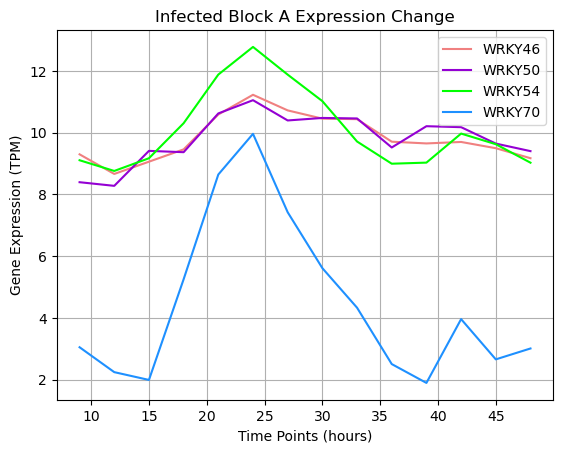

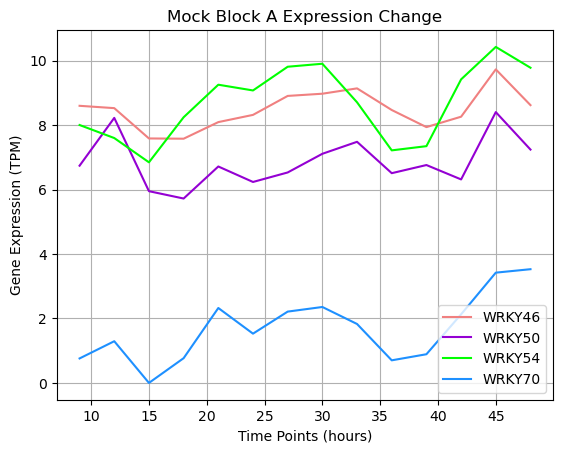

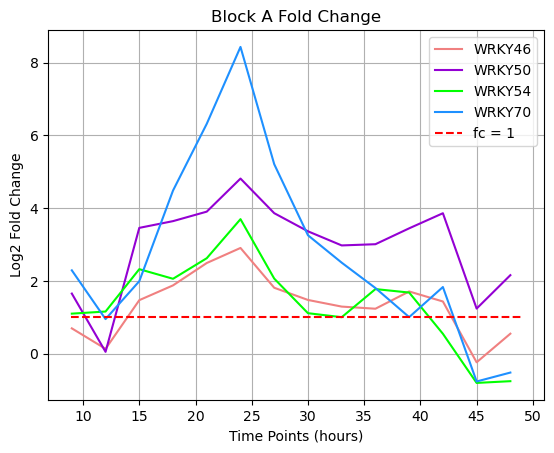

In [3]:
# plotting infection expression data
timepoints = np.arange(9,51,3)
plt.plot(timepoints, inf_expA_df.iloc[0,1:15], label = "WRKY46", color = "lightcoral") 
plt.plot(timepoints, inf_expA_df.iloc[1,1:15], label = "WRKY50", color = "darkviolet")
plt.plot(timepoints, inf_expA_df.iloc[2,1:15], label = "WRKY54", color = "lime")
plt.plot(timepoints, inf_expA_df.iloc[3,1:15], label = "WRKY70", color = "dodgerblue")
plt.legend(loc='best')
plt.xlabel('Time Points (hours)')
plt.ylabel('Gene Expression (TPM)')
plt.title("Infected Block A Expression Change")
plt.grid()
plt.show()

# plotting mock expression data
plt.plot(timepoints, mock_expA_df.iloc[0,1:15], label = "WRKY46", color = "lightcoral") 
plt.plot(timepoints, mock_expA_df.iloc[1,1:15], label = "WRKY50", color = "darkviolet")
plt.plot(timepoints, mock_expA_df.iloc[2,1:15], label = "WRKY54", color = "lime")
plt.plot(timepoints, mock_expA_df.iloc[3,1:15], label = "WRKY70", color = "dodgerblue")
plt.legend(loc='best')
plt.xlabel('Time Points (hours)')
plt.ylabel('Gene Expression (TPM)')
plt.title("Mock Block A Expression Change")
plt.grid()
plt.show()

real_46 = inf_expA_df.iloc[0,1:15]
real_50 = inf_expA_df.iloc[1,1:15]
real_54 = inf_expA_df.iloc[2,1:15]
real_70 = inf_expA_df.iloc[3,1:15]

real_inf_dict = {'WRKY46': real_46,
                 'WRKY50': real_50,
                 'WRKY54': real_54,
                 'WRKY70': real_70}
real_inf_df = pd.concat(real_inf_dict,
               axis = 1)

# Plotting Log Fold Change Across Time Series

timepoints = np.arange(9,51,3)

# creating variables to hold the data i need to plot

network_fc = limma_df[limma_df["At_ShortName"].str.contains("WRKY70|WRKY54|WRKY46|WRKY50",na=False)]
network_fc = network_fc.sort_values('At_ShortName') #data is now sorted alphabetically:BBX15_1,BBX15_2,GPRI1,WRKY46,WRKY50,WRKY54_1,WRKY54_2,WRKY70_1,WRKY70_2

foldchange = network_fc.loc[:,'log2FC_tp9':'log2FC_tp48']
foldchange.iloc[0]

plt.plot(timepoints, foldchange.iloc[0], label = "WRKY46", color = "lightcoral") 
plt.plot(timepoints, foldchange.iloc[1], label = "WRKY50", color = "darkviolet")
plt.plot(timepoints, foldchange.iloc[3], label = "WRKY54", color = "lime")
plt.plot(timepoints, foldchange.iloc[5], label = "WRKY70", color = "dodgerblue")
plt.xlabel('Time Points (hours)')
plt.ylabel('Log2 Fold Change')
plt.title("Block A Fold Change")
plt.hlines(1, 8.9, 49, "r","dashed", label = 'fc = 1')
plt.legend(loc='best')
plt.grid()
plt.show()

# need to find confidence intervals
# ax.fill_between( x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.15)


In [4]:
#importing and organsing data - change file paths as needed.
#mean expression is extracted and At gene names added.

zeros = np.zeros((37828,1))
mean_exp = pd.read_csv("//Users/guf24vol/Documents/morris_lettuce_rotation/my_lettuce/fc_cinerea_wsterr.csv", sep =',', header = 0) #note that i made this file in excel from the original data
mean_exp_df2 = pd.DataFrame(mean_exp)
mean_exp_df2['GeneID_mock'] = mean_exp_df2['GeneID']
mean_exp_df2.insert(1, 'At_geneID', zeros)
mean_exp_df2.insert(59, 'At_geneID1', zeros)

at_geneid = {'Lsat_1_v5_gn_3_139241': 'WRKY46', 'Lsat_1_v5_gn_7_60801': 'WRKY50','Lsat_1_v5_gn_2_126880': 'WRKY54','Lsat_1_v5_gn_9_38680':'WRKY70'}
mean_exp_df2['At_geneID'] = mean_exp_df2['GeneID'].map(at_geneid)
mean_exp_df2['At_geneID1'] = mean_exp_df2['GeneID'].map(at_geneid)

mean_inf = mean_exp_df2.iloc[:,0:30]
mean_mock = mean_exp_df2.iloc[:,30:60]

inf_sterr_df= mean_inf[mean_inf["GeneID"].str.contains("Lsat_1_v5_gn_3_139241|Lsat_1_v5_gn_7_60801|Lsat_1_v5_gn_2_126880|Lsat_1_v5_gn_9_38680",na=False)]
mock_sterr_df= mean_mock[mean_mock["GeneID_mock"].str.contains("Lsat_1_v5_gn_3_139241|Lsat_1_v5_gn_7_60801|Lsat_1_v5_gn_2_126880|Lsat_1_v5_gn_9_38680",na=False)]

inf_sterr_df = inf_sterr_df.sort_values('At_geneID') #data is now sorted alphabetically:WRKY46,WRKY50,WRKY54,WRKY70
mock_sterr_df = mock_sterr_df.sort_values('At_geneID1') #data is now sorted alphabetically:WRKY46,WRKY50,WRKY54,WRKY70

# limma_data = pd.read_csv("/Users/guf24vol/Documents/lettuce/lettuce_data/limma_sup3.csv", sep =',', header = 1)
# limma_df = pd.DataFrame(limma_data)

In [5]:
#having calculated the standard error in excel, ive now added the upper and lower confidence intervals... what a drama!

tp_list = np.arange(9,51,3)

df_new = inf_sterr_df
for tp in tp_list:
    if tp < 10:
        df_new[f'ci_lower_0{tp}'] = df_new[f'Infected_tp0{tp}_mean'] - df_new[f'Infected_tp0{tp}_sterr']
        df_new[f'ci_upper_0{tp}'] = df_new[f'Infected_tp0{tp}_mean'] + df_new[f'Infected_tp0{tp}_sterr']
    elif tp < 47:
        df_new[f'ci_lower_{tp}'] = df_new[f'Infected_tp{tp}_mean'] - df_new[f'Infected_tp{tp}_sterr']
        df_new[f'ci_upper_{tp}'] = df_new[f'Infected_tp{tp}_mean'] + df_new[f'Infected_tp{tp}_sterr']
    else:
        df_new[f'ci_lower_{tp}'] = df_new[f'Infected_tp{tp}_mean2'] - df_new[f'Infected_tp{tp}_sterr']
        df_new[f'ci_upper_{tp}'] = df_new[f'Infected_tp{tp}_mean2'] + df_new[f'Infected_tp{tp}_sterr'] #i made a typo in excel...
inf_exp_ci = df_new


df_new = mock_sterr_df
i = 0
for tp in tp_list:
    if tp < 10:
        df_new[f'ci_lower_0{tp}'] = df_new[f'Mock_tp0{tp}_mean'] - df_new[f'Mock_tp0{tp}_sterr']
        df_new[f'ci_upper_0{tp}'] = df_new[f'Mock_tp0{tp}_mean'] + df_new[f'Mock_tp0{tp}_sterr']
    else:
        df_new[f'ci_lower_{tp}'] = df_new[f'Mock_tp{tp}_mean'] - df_new[f'Mock_tp{tp}_sterr']
        df_new[f'ci_upper_{tp}'] = df_new[f'Mock_tp{tp}_mean'] + df_new[f'Mock_tp{tp}_sterr']
    i = i + 2
mock_exp_ci = df_new


mock_exp_lower = mock_exp_ci.filter(like='lower')
mock_exp_upper = mock_exp_ci.filter(like='upper')

inf_exp_lower = inf_exp_ci.filter(like='lower')
inf_exp_upper = inf_exp_ci.filter(like='upper')

# i made this way harder than i should've, and probably could've used df.filter from the start. oh well!

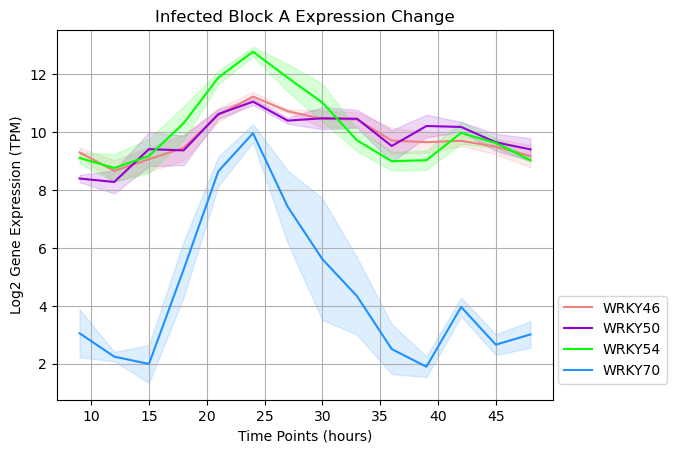

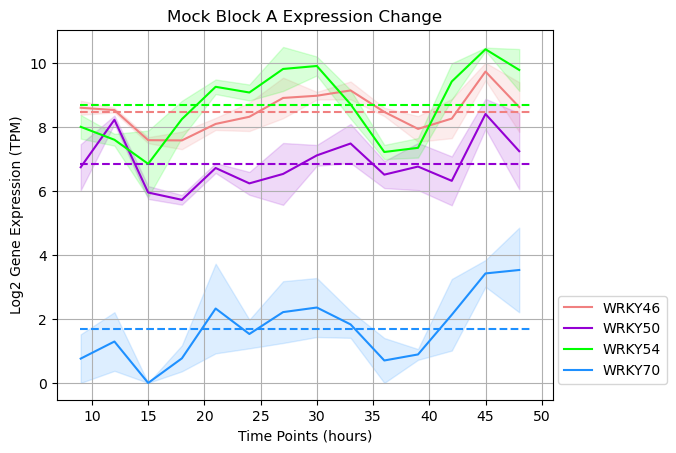

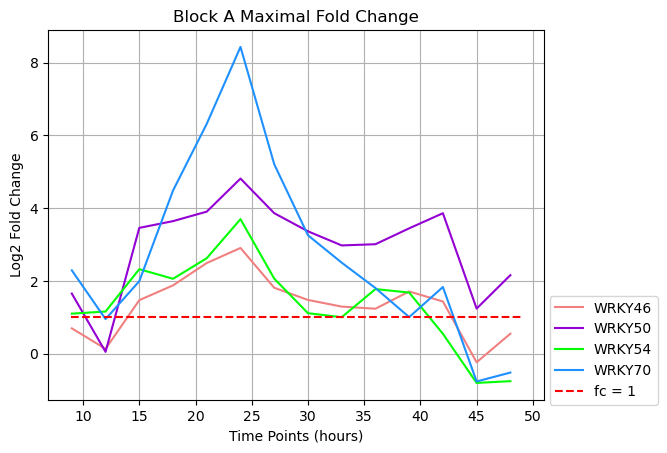

In [6]:
# plotting infection expression data
timepoints = np.arange(9,51,3)
plt.plot(timepoints, inf_expA_df.iloc[0,1:15], label = "WRKY46", color = "lightcoral")
plt.fill_between(
    timepoints, inf_exp_lower.iloc[0,0:15], inf_exp_upper.iloc[0,0:15], color="lightcoral", alpha=.15)
plt.plot(timepoints, inf_expA_df.iloc[1,1:15], label = "WRKY50", color = "darkviolet")
plt.fill_between(
    timepoints, inf_exp_lower.iloc[1,0:15], inf_exp_upper.iloc[1,0:15], color="darkviolet", alpha=.15)
plt.plot(timepoints, inf_expA_df.iloc[2,1:15], label = "WRKY54", color = "lime")
plt.fill_between(
    timepoints, inf_exp_lower.iloc[2,0:15], inf_exp_upper.iloc[2,0:15], color="lime", alpha=.15)
plt.plot(timepoints, inf_expA_df.iloc[3,1:15], label = "WRKY70", color = "dodgerblue")
plt.fill_between(
    timepoints, inf_exp_lower.iloc[3,0:15], inf_exp_upper.iloc[3,0:15], color="dodgerblue", alpha=.15)
plt.legend(loc='upper center', bbox_to_anchor=(1.12, 0.30),
          ncol=1, fancybox=True)
plt.xlabel('Time Points (hours)')
plt.ylabel('Log2 Gene Expression (TPM)')
plt.title("Infected Block A Expression Change")
plt.grid()
plt.show()

#finding the means of mock data
mean_46 = np.mean(mock_expA_df.iloc[0,1:15])
mean_50 = np.mean(mock_expA_df.iloc[1,1:15])
mean_54 = np.mean(mock_expA_df.iloc[2,1:15])
mean_70 = np.mean(mock_expA_df.iloc[3,1:15])

# plotting mock expression data
plt.plot(timepoints, mock_expA_df.iloc[0,1:15], label = "WRKY46", color = "lightcoral")
plt.hlines(mean_46, 8.9, 49, "r","dashed",color = "lightcoral")
plt.fill_between(
    timepoints, mock_exp_lower.iloc[0,0:15], mock_exp_upper.iloc[0,0:15], color="lightcoral", alpha=.15) 
plt.plot(timepoints, mock_expA_df.iloc[1,1:15], label = "WRKY50", color = "darkviolet")
plt.hlines(mean_50, 8.9, 49, "r","dashed", color = "darkviolet")
plt.fill_between(
    timepoints, mock_exp_lower.iloc[1,0:15], mock_exp_upper.iloc[1,0:15], color="darkviolet", alpha=.15)
plt.plot(timepoints, mock_expA_df.iloc[2,1:15], label = "WRKY54", color = "lime")
plt.hlines(mean_54, 8.9, 49, "r","dashed", color = "lime")
plt.fill_between(
    timepoints, mock_exp_lower.iloc[2,0:15], mock_exp_upper.iloc[2,0:15], color="lime", alpha=.15)
plt.plot(timepoints, mock_expA_df.iloc[3,1:15], label = "WRKY70", color = "dodgerblue")
plt.hlines(mean_70, 8.9, 49, "r","dashed", color = "dodgerblue")
plt.fill_between(
    timepoints, mock_exp_lower.iloc[3,0:15], mock_exp_upper.iloc[3,0:15], color="dodgerblue", alpha=.15)
plt.legend(loc='upper center', bbox_to_anchor=(1.12, 0.30),
          ncol=1, fancybox=True)
plt.xlabel('Time Points (hours)')
plt.ylabel('Log2 Gene Expression (TPM)')
plt.title("Mock Block A Expression Change")
plt.grid()
plt.show()

real_46 = inf_expA_df.iloc[0,1:15]
real_50 = inf_expA_df.iloc[1,1:15]
real_54 = inf_expA_df.iloc[2,1:15]
real_70 = inf_expA_df.iloc[3,1:15]

real_inf_dict = {'WRKY46': real_46,
                 'WRKY50': real_50,
                 'WRKY54': real_54,
                 'WRKY70': real_70}
real_inf_df = pd.concat(real_inf_dict,
               axis = 1)

# Plotting Log Fold Change Across Time Series

timepoints = np.arange(9,51,3)

# creating variables to hold the data i need to plot

network_fc = limma_df[limma_df["At_ShortName"].str.contains("WRKY70|WRKY54|WRKY46|WRKY50",na=False)]
network_fc = network_fc.sort_values('At_ShortName') #data is now sorted alphabetically:BBX15_1,BBX15_2,GPRI1,WRKY46,WRKY50,WRKY54_1,WRKY54_2,WRKY70_1,WRKY70_2

foldchange = network_fc.loc[:,'log2FC_tp9':'log2FC_tp48']
foldchange.iloc[0]

plt.plot(timepoints, foldchange.iloc[0], label = "WRKY46", color = "lightcoral") 
plt.plot(timepoints, foldchange.iloc[1], label = "WRKY50", color = "darkviolet")
plt.plot(timepoints, foldchange.iloc[3], label = "WRKY54", color = "lime")
plt.plot(timepoints, foldchange.iloc[5], label = "WRKY70", color = "dodgerblue")
plt.xlabel('Time Points (hours)')
plt.ylabel('Log2 Fold Change')
plt.title("Block A Maximal Fold Change")
plt.hlines(1, 8.9, 49, "r","dashed", label = 'fc = 1')
plt.legend(loc='upper center', bbox_to_anchor=(1.12, 0.30),
          ncol=1, fancybox=True)
plt.grid()
plt.show()



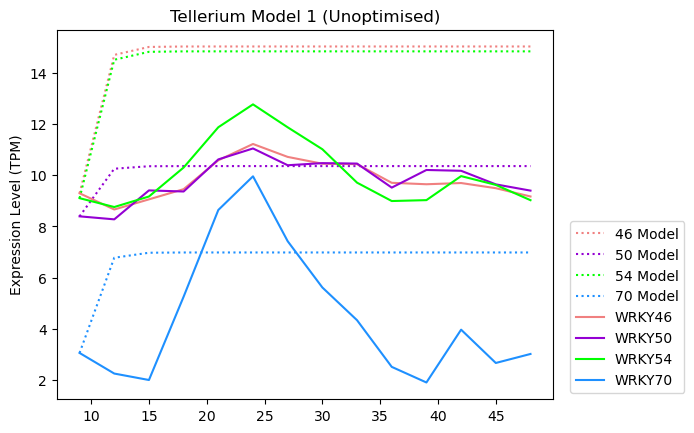

In [7]:
#modelling the tellerium string for reference
#all beta = 2, all k = 2, ST = TP09 infection expression level.


tell_str_hold = """
# assuming transcription factors are present in the system, activated/inactivated at a low equilibrium
-> WRKY46; alpha_46 - delta*WRKY46; #assuming ST = inf tp09 (unlikely); decay happens in proportion to product
-> WRKY50; alpha_50 - delta*WRKY50; 
-> WRKY54; alpha_54 - delta*WRKY54; 
-> WRKY70; alpha_70 - delta*WRKY70;

# modelling interactions between transcription factors as hill functions.

#controlled by WRKY46
-> WRKY50 ; beta_50*((WRKY46^n)/(k46_50^n+WRKY46^n));
-> WRKY54 ; beta_54*((WRKY46^n)/(k46_54^n+WRKY46^n));
-> WRKY70 ; beta_70*((WRKY46^n)/(k46_70^n+WRKY46^n));

#controlled by WRKY50
-> WRKY46 ; beta_46*((WRKY50^n)/(k50_46^n+WRKY50^n));
-> WRKY54 ; beta_54*((WRKY50^n)/(k50_54^n+WRKY50^n));

#controlled by WRKY54
-> WRKY46 ; beta_46*((WRKY54^n)/(k54_46^n+WRKY54^n));
-> WRKY70 ; beta_70*((WRKY54^n)/(k54_70^n+WRKY54^n));

#controlled by WRKY70
-> WRKY46 ; beta_46*((WRKY70^n)/(k70_46^n+WRKY70^n));
-> WRKY54 ; beta_54*((WRKY70^n)/(k70_54^n+WRKY70^n));

#using initial expression data from mean TP09 infected
WRKY46 = 9.295879; WRKY50 = 8.39353; WRKY54 = 9.104284; WRKY70 = 3.0511;

alpha_46 = 9.295879 # activation constant/transcription rates
alpha_50 = 8.39353
alpha_54 = 9.104284
alpha_70 = 3.0511

n = 2
delta = 1 # inactivation/decay constant


beta_46 = 2
beta_50 = 2
beta_54 = 2
beta_70 = 2

k46_50 = 2
k46_54 = 2
k46_70 = 2
k50_46 = 2
k50_54 = 2
k54_46 = 2
k54_70 = 2
k70_46 = 2
k70_54 = 2
"""

blockA_str = tell_str_hold
r = te.loada(blockA_str)
results = r.simulate(int(timepoints[0]),int(timepoints[-1]),int(len(timepoints)))

# reorganising results to then plot with matching colour scheme as data
results_df = pd.DataFrame(results)
results_df = results_df.rename(columns={0:'time',1:'WRKY46', 2:'WRKY50', 3:'WRKY54', 4:'WRKY70'})


plt.title('Tellerium Model 1 (Unoptimised)')
plt.plot(results_df['time'], results_df['WRKY46'], color='lightcoral', label='46 Model', linestyle = ':')
plt.plot(results_df['time'], results_df['WRKY50'], color='darkviolet', label='50 Model',linestyle = ':')
plt.plot(results_df['time'], results_df['WRKY54'], color='lime', label='54 Model',linestyle = ':')
plt.plot(results_df['time'], results_df['WRKY70'], color='dodgerblue', label='70 Model',linestyle = ':')
plt.plot(timepoints, inf_expA_df.iloc[0,1:15], label = "WRKY46", color = "lightcoral") 
plt.plot(timepoints, inf_expA_df.iloc[1,1:15], label = "WRKY50", color = "darkviolet")
plt.plot(timepoints, inf_expA_df.iloc[2,1:15], label = "WRKY54", color = "lime")
plt.plot(timepoints, inf_expA_df.iloc[3,1:15], label = "WRKY70", color = "dodgerblue")
plt.ylabel('Expression Level (TPM)', fontsize=10)

plt.legend(loc='upper center', bbox_to_anchor=(1.15, 0.5),
          ncol=1, fancybox=True)

## Curvefit() example: simulated hill function

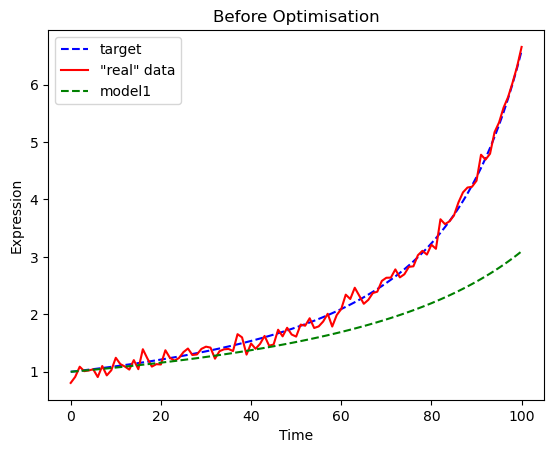

In [8]:
#data generation
xdata = np.linspace(0,100,101)

target_curve = []
X0 = 1
beta = 2
k = 15
for t in xdata:  #our 'target', which we'll use to make noisy 'real data'
    target_curve.append(X0)
    X1 = X0 + beta*((X0**2)/(k**2+X0**2))
    X0 = X1

# fit data with noise
rng = np.random.default_rng()
y_noise = 0.1 * rng.normal(size=xdata.size)
real_y = list(target_curve + y_noise) #we will use this as our "real data"

model1 = [] #this matches what the hillfun produces with base parametres
X0 = 1
for t in xdata:
    model1.append(X0)
    X1 = X0 + beta*((X0**2)/(17**2+X0**2)) #k = 17
    X0 = X1


plt.plot(xdata, target_curve, 'b--', label = 'target')
plt.plot(xdata,real_y, 'r', label = '"real" data')
plt.plot(xdata, model1, '--', color = 'green', label = 'model1') #this is what the hillfun produces with set parametres
plt.xlabel('Time')
plt.ylabel('Expression')
plt.title("Before Optimisation")
plt.legend(loc = 'best')

In [9]:
# optimising beta and k with curvefit


def cv_hillfun(time, beta, k):
    hill_results = []
    X0 = 1
    b_value = beta
    k_value = k
    for t in time:
        hill_results.append(X0)
        X1 = X0 + b_value*((X0**2)/(k_value**2+X0**2))
        X0 = X1
    sq_err = mean_squared_error(real_y,hill_results)
    filepath = "/Users/guf24vol/Documents/training/training/minimise_output/curvefit.txt"
    original = sys.stdout
    sys.stdout = open(filepath, "a") #note, need to make a new file eachtime this is ran
    print(f"{b_value},{k_value},{sq_err}")
    sys.stdout = original
    return hill_results

popt1, pcov1 = curve_fit(cv_hillfun,xdata,real_y,[2,20]) #popt1 and pcov1 correspond to when both beta and k are fit
print(popt1,pcov1)

# each cv_hillfun is run, it ADDS to an existing output file, if one already exists. so PLEASE! delete the file before running it.
df = pd.read_csv("minimise_output/curvefit.txt", header=0, names = ["beta", "k", "sq_err"])
    

[ 2.16148328 15.59360016] [[0.39131242 1.4414447 ]
 [1.4414447  5.30983293]]


In [10]:
# holding beta constant
def cv_hillfun(time, k):
    hill_results = []
    X0 = 1
    b_value = 2
    k_value = k
    for t in time:
        hill_results.append(X0)
        X1 = X0 + b_value*((X0**2)/(k_value**2+X0**2))
        X0 = X1
    return hill_results

popt2, pcov2 = curve_fit(cv_hillfun,xdata,real_y,[20])
print(popt2,pcov2) #popt2 and pcov2 correspond to when only k is fit; beta = 2

[14.98691971] [[9.69126196e-05]]


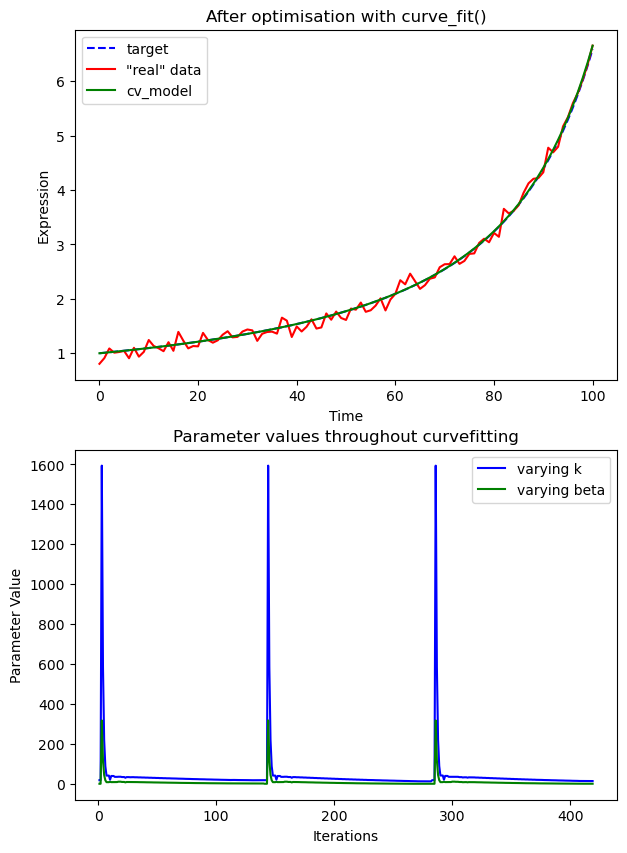

In [11]:
#plotting the minimised square error against k and beta values; these are a good example of how this function works.

def hillfun(time, beta = 2.556, k = 15):
    hill_results = []
    X0 = 1
    time_loop = np.arange(0,time+1,1)
    for t in time_loop:
        hill_results.append(X0)
        X1 = X0 + beta*((X0**2)/(k**2+X0**2))
        X0 = X1
    return hill_results

test = df
# test = df.drop(index=[0,1,2,3,4,5,6,7,8,10,11,12,13]) #so, what's interesting, is that without this line, the below graph makes no sense, just because of the scale it works at
time =len(xdata) -1
beta_array = test['beta']
k_array = test['k']
lstsq_list = test['sq_err']
iterations = np.linspace(1, len(beta_array),len(beta_array))

cv_hill_results3 = hillfun(time = 100, beta = popt1[0], k = popt1[1])

fig, ax = plt.subplots(2,1, figsize=(7,10))

plt.subplot(2,1,1)
plt.plot(xdata, target_curve, 'b--', label = 'target')
plt.plot(xdata,real_y, 'r', label = '"real" data')
# plt.plot(xdata, min_hill_results1, '-', color = 'green', label = 'min_model_k', linestyle = '--')
# plt.plot(xdata, min_hill_results2, '-', color = 'green', label = 'min_model_b')
plt.plot(xdata, cv_hill_results3, '-',color = 'green', label = 'cv_model')
plt.ylabel('Expression')
plt.xlabel('Time')
plt.title("After optimisation with curve_fit()")
plt.legend(loc = "best")

plt.subplot(2,1,2)
plt.plot(iterations, k_array, 'b-', label = 'varying k')
plt.plot(iterations, beta_array, 'g-', label = 'varying beta')
plt.xlabel("Iterations")
plt.ylabel("Parameter Value")
plt.title('Parameter values throughout curvefitting')
plt.legend(loc = 'best')

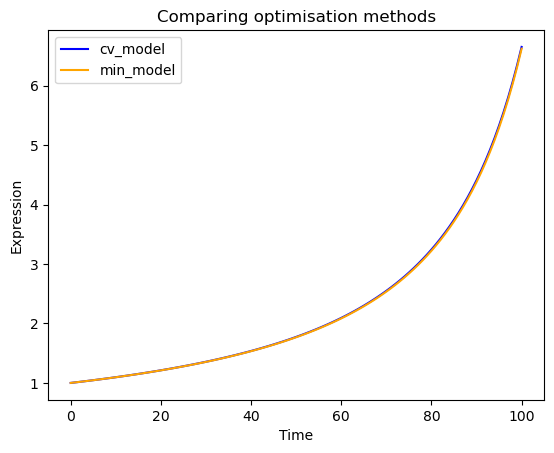

In [12]:
targ_hill_results1 = hillfun(time = 100, beta = 2, k = 15)
min_hill_results2 = hillfun(time = 100, beta = 2.556, k = 17)

# plt.plot(xdata, target_curve, 'b--', label = 'target')
# plt.plot(xdata,real_y, 'r', label = '"real" data')
plt.plot(xdata, cv_hill_results3, '-',color = 'blue', label = 'cv_model')
plt.plot(xdata, min_hill_results2, '-',color = 'orange', label = 'min_model')
plt.ylabel('Expression')
plt.xlabel('Time')
plt.title("Comparing optimisation methods")
plt.legend(loc = "best")

## Minimise() example: simulated hill function

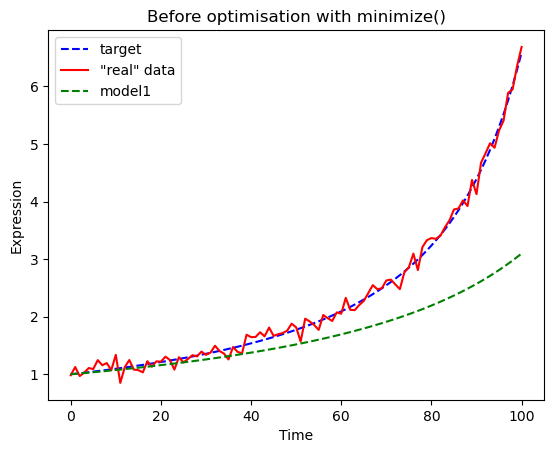

In [13]:
#data generation
xdata = np.linspace(0,100,101)

target_curve = []
X0 = 1
beta = 2
k = 15
for t in xdata:  #our 'target', which we'll use to make noisy 'real data'
    target_curve.append(X0)
    X1 = X0 + beta*((X0**2)/(k**2+X0**2))
    X0 = X1

# fit data with noise
rng = np.random.default_rng()
y_noise = 0.1 * rng.normal(size=xdata.size)
real_y = list(target_curve + y_noise) #we will use this as our "real data"

model1 = [] #this matches what the hillfun produces with base parametres
X0 = 1
for t in xdata:
    model1.append(X0)
    X1 = X0 + beta*((X0**2)/(17**2+X0**2)) #k = 17
    X0 = X1


plt.plot(xdata, target_curve, 'b--', label = 'target')
plt.plot(xdata,real_y, 'r', label = '"real" data')
plt.plot(xdata, model1, '--', color = 'green', label = 'model1') #this is what the hillfun produces with set parametres
plt.xlabel('Time')
plt.ylabel('Expression')
plt.title("Before optimisation with minimize()")
plt.legend(loc = 'best')

In [14]:

def mmte_example(variables, time, title):
    """
    Let variables be a list [beta,k], and time an array.
    """
    if len(variables) != 2:
        raise Exception("unexpected variable input") 
    else:
        data = real_y
        b_value = variables[0]
        k_value = variables[1]
        hill_results = []
        X0 = 1
        for t in time:
            hill_results.append(X0)
            X1 = X0 + b_value*((X0**2)/(k_value**2+X0**2))
            X0 = X1
        sq_err = mean_squared_error(data,hill_results)
        filepath = "/Users/guf24vol/Documents/training/training/minimise_output/" + f"{title}.txt"
        original = sys.stdout
        sys.stdout = open(filepath, "a") #note, need to make a new file eachtime this is ran
        print(f"{b_value},{k_value},{sq_err}")
        sys.stdout = original
        return sq_err
    
example = minimize(mmte_example,[2,20],(xdata, "beta_k2_2"))
print(example)

df = pd.read_csv("minimise_output/beta_k2_2.txt", header=0, names = ["beta", "k", "sq_err"])
print(df)
    

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.011604804582884907
        x: [ 1.781e+00  1.413e+01]
      nit: 49
      jac: [-3.379e-06  8.575e-07]
 hess_inv: [[ 8.164e+02  3.321e+03]
            [ 3.321e+03  1.351e+04]]
     nfev: 198
     njev: 66
         beta          k    sq_err
0    2.000000  20.000000  2.016734
1    2.000000  20.000000  2.016734
2    2.990554  19.802763  0.560640
3    2.990554  19.802763  0.560640
4    2.990554  19.802763  0.560640
..        ...        ...       ...
417  1.781510  14.129484  0.011605
418  1.781510  14.129484  0.011605
419  1.780728  14.126301  0.011605
420  1.780728  14.126301  0.011605
421  1.780728  14.126301  0.011605

[422 rows x 3 columns]


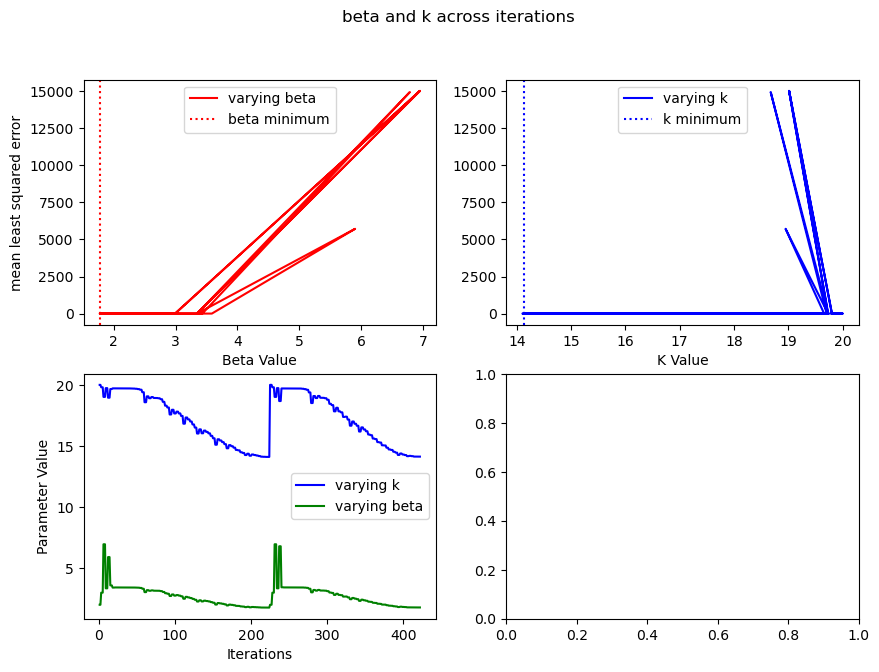

In [15]:
#plotting the minimised square error against k and beta values; these are a good example of how this function works.

test = df
# test = df.drop(index=[0,1,2,3,4,5,6,7,8,10,11,12,13]) #so, what's interesting, is that without this line, the below graph makes no sense, just because of the scale it works at
time =len(xdata) -1
beta_array = test['beta']
k_array = test['k']
lstsq_list = test['sq_err']
iterations = np.linspace(1, len(beta_array),len(beta_array))

fig, ax = plt.subplots(2, 2, figsize=(10,7))

plt.subplot(2,2,1)
plt.plot(beta_array, lstsq_list, 'r-', label = 'varying beta')
plt.xlabel("Beta Value")
plt.ylabel('mean least squared error')
plt.axvline(example.x[0], color = 'r', linestyle = ':', label = "beta minimum")
plt.legend(loc = 'best')

plt.subplot(2,2,2)
plt.plot(k_array, lstsq_list, 'b-', label = 'varying k')
plt.xlabel("K Value")
plt.suptitle('mean least squared error with varying beta and k')
plt.axvline(example.x[1], color = 'b', linestyle = ':', label = "k minimum")
plt.legend(loc = 'best')

plt.subplot(2,2,3)
plt.plot(iterations, k_array, 'b-', label = 'varying k')
plt.plot(iterations, beta_array, 'g-', label = 'varying beta')
plt.xlabel("Iterations")
plt.ylabel("Parameter Value")
plt.suptitle('beta and k across iterations')
plt.legend(loc = 'best')

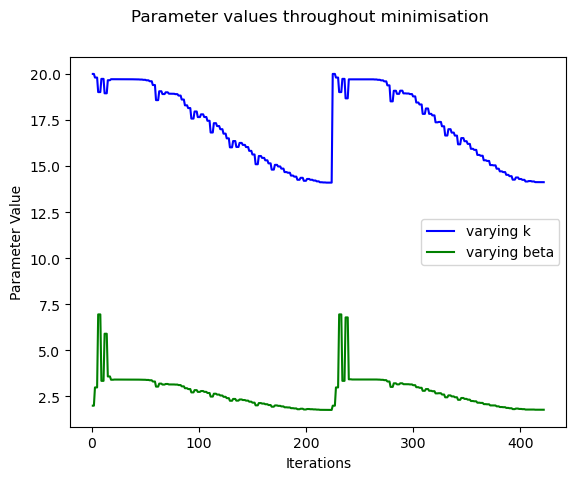

In [16]:
plt.plot(iterations, k_array, 'b-', label = 'varying k')
plt.plot(iterations, beta_array, 'g-', label = 'varying beta')
plt.xlabel("Iterations")
plt.ylabel("Parameter Value")
plt.suptitle('Parameter values throughout minimisation')
plt.legend(loc = 'best')

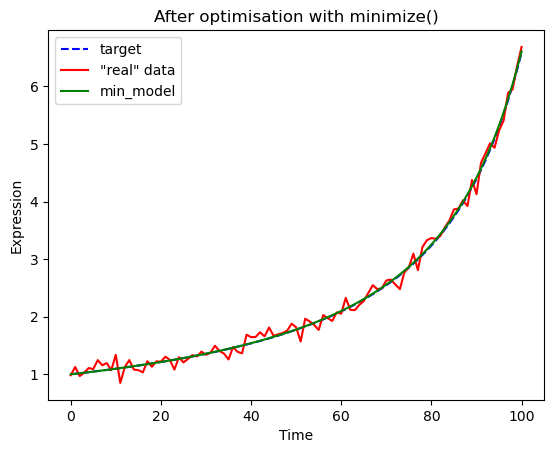

In [17]:
#try and apply these results to a hill function to minimise error
def hillfun(time, beta = 2.556, k = 15):
    hill_results = []
    X0 = 1
    time_loop = np.arange(0,time+1,1)
    for t in time_loop:
        hill_results.append(X0)
        X1 = X0 + beta*((X0**2)/(k**2+X0**2))
        X0 = X1
    return hill_results

min_hill_results1 = hillfun(time = 100, beta = 2, k = 15)
min_hill_results2 = hillfun(time = 100, beta = 2.556, k = 17)
min_hill_results3 = hillfun(time = 100, beta = 1.772, k = 14.08839456)


plt.plot(xdata, target_curve, 'b--', label = 'target')
plt.plot(xdata,real_y, 'r', label = '"real" data')
# plt.plot(xdata, min_hill_results1, '-', color = 'green', label = 'min_model_k', linestyle = '--')
# plt.plot(xdata, min_hill_results2, '-', color = 'green', label = 'min_model_b')
plt.plot(xdata, min_hill_results3, '-',color = 'green', label = 'min_model')
plt.ylabel('Expression')
plt.xlabel('Time')
plt.title("After optimisation with minimize()")
plt.legend(loc = "best")

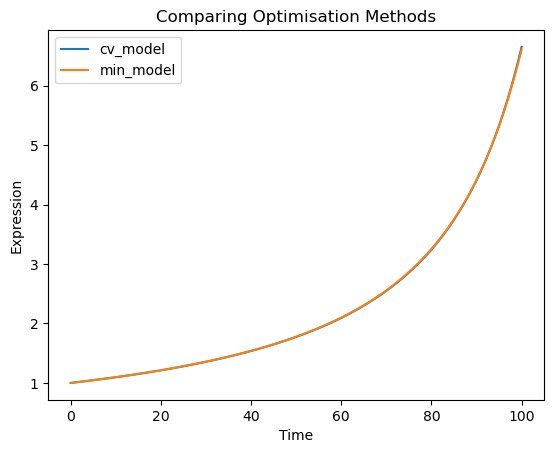

In [18]:
plt.plot(xdata, cv_hill_results3, '-', label = 'cv_model')
plt.plot(xdata, min_hill_results3, '-', label = 'min_model')
plt.ylabel('Expression')
plt.xlabel('Time')
plt.title("Comparing Optimisation Methods")
plt.legend(loc = "best")

## Using curve_fit() on the Tellerium Model
we will use the same string as in the minimize model

In [8]:
#tellerium string with placeholders where we require values to be changed.

tell_str_var = """
# keeping these parametres constant for now
-> WRKY46; alpha_46 - delta*WRKY46;
-> WRKY50; alpha_50 - delta*WRKY50; 
-> WRKY54; alpha_54 - delta*WRKY54; 
-> WRKY70; alpha_70 - delta*WRKY70;

# modelling interactions between transcription factors as hill functions. keeping n constant

#controlled by WRKY46
-> WRKY50 ; beta_50*((WRKY46^n)/(K46_50^n+WRKY46^n));
-> WRKY54 ; beta_54*((WRKY46^n)/(K46_54^n+WRKY46^n));
-> WRKY70 ; beta_70*((WRKY46^n)/(K46_70^n+WRKY46^n));

#controlled by WRKY50
-> WRKY46 ; beta_46*((WRKY50^n)/(K50_46^n+WRKY50^n));
-> WRKY54 ; beta_54*((WRKY50^n)/(K50_54^n+WRKY50^n));

#controlled by WRKY54
-> WRKY46 ; beta_46*((WRKY54^n)/(K54_46^n+WRKY54^n));
-> WRKY70 ; beta_70*((WRKY54^n)/(K54_70^n+WRKY54^n));

#controlled by WRKY70
-> WRKY46 ; beta_46*((WRKY70^n)/(K70_46^n+WRKY70^n));
-> WRKY54 ; beta_54*((WRKY70^n)/(K70_54^n+WRKY70^n));

#using initial expression data from mean TP09 infected
WRKY46 = 9.295879; WRKY50 = 8.39353; WRKY54 = 9.104284; WRKY70 = 3.0511;

alpha_46 = 9.295879 # activation constant/transcription rates
alpha_50 = 8.39353
alpha_54 = 9.104284
alpha_70 = 3.0511
n = 2
delta = 1 # inactivation/decay constant

beta_46 = {beta_46}
beta_50 = {beta_50}
beta_54 = {beta_54}
beta_70 = {beta_70}

K46_50 = {k46_50}
K46_54 = {k46_54}
K46_70 = {k46_70}
K50_46 = {k50_46}
K50_54 = {k50_54}
K54_46 = {k54_46}
K54_70 = {k54_70}
K70_46 = {k70_46}
K70_54 = {k70_54}

"""

In [9]:
#this dictionary will be copied within cvte_tool. The copy is then modified and used to set parameters withint the Tellerium string at the placeholders.

cvte_parameters ={'beta_46':2, 'beta_50':2, 'beta_54':2, 'beta_70':2, 'k46_50':2, 'k46_70':2, 'k46_54':2, 'k50_46':2,'k50_54':2, 'k54_46':2, 'k54_70':2, 'k70_46':2, 'k70_54':2}

In [10]:
def cvte_tool2(time,variable0,variable1,variable2,variable3,variable4,variable5,variable6,variable7,variable8,variable9,variable10,variable11,variable12):
    cvte_parameters_temp = cvte_parameters.copy()
    cvte_parameters_temp['beta_46'] = variable0 #sorry... this is so ugly </3
    cvte_parameters_temp['beta_50'] = variable1
    cvte_parameters_temp['beta_54'] = variable2
    cvte_parameters_temp['beta_70'] = variable3
    cvte_parameters_temp['k46_50'] = variable4
    cvte_parameters_temp['k46_54'] = variable5
    cvte_parameters_temp['k46_70'] = variable6
    cvte_parameters_temp['k50_46'] = variable7
    cvte_parameters_temp['k50_54'] = variable8
    cvte_parameters_temp['k54_46'] = variable9
    cvte_parameters_temp['k54_70'] = variable10
    cvte_parameters_temp['k70_46'] = variable11
    cvte_parameters_temp['k70_54'] = variable12
    #inputting parameters into string and running it through tellurium
    str = tell_str_var.format(**cvte_parameters_temp)
    r = te.loada(str)
    results = r.simulate(int(time[0]),int(time[-1]),int(len(time)))
    results_df = pd.DataFrame(results)
    wrky46 = np.array(results_df[1])
    wrky50 = np.array(results_df[2])
    wrky54 = np.array(results_df[3])
    wrky70 = np.array(results_df[4])
    err_dict_temp ={}
    err_list = []
    n = 1
    tot_sq_err = 0
    for gene in real_inf_df:
        pred = results_df.iloc[:,n]
        sq_mean_err = mean_squared_error(pred,real_inf_df[gene])
        err_dict_temp[n] = [sq_mean_err]
        err_list.append(sq_mean_err)
        tot_sq_err += sq_mean_err
        n += 1
    err_list = err_list + [0,0,0,0,0,0,0,0,0]
    filepath = "/Users/guf24vol/Documents/training/training/minimise_output/boss_cv.txt"
    original = sys.stdout
    sys.stdout = open(filepath, "a") #note, need to make a new file eachtime this is ran
    print(f"{variable0},{variable1},{variable2},{variable3},{variable4},{variable5},{variable6},{variable7},{variable8},{variable9},{variable10},{variable11},{variable12},{tot_sq_err}, {err_list}")
    sys.stdout = original
    return err_list

In [11]:
time = np.arange(9,51,3)
guess = tuple(np.full((13,), 2))
nowpls =(np.shape(real_inf_df),np.shape(time),np.shape(guess))
inf_real_array = real_inf_df.to_numpy()

variable0,variable1,variable2,variable3,variable4,variable5,variable6,variable7,variable8,variable9,variable10,variable11,variable12 = guess

test_results = cvte_tool2(time,variable0,variable1,variable2,variable3,variable4,variable5,variable6,variable7,variable8,variable9,variable10,variable11,variable12)
print(test_results)
# boss_cv_popt,boss_cv_pcov = curve_fit(cvte_tool,time,inf_real_array,guess)

NameError: name 'sys' is not defined

In [115]:
#running curve_fit on the above function.

time = np.arange(9,51,3)
sq_err = 0 #pls

guess = tuple(np.full((13,), 2))
boss_cv_popt,boss_cv_pcov = curve_fit(cvte_tool2,time,sq_err,guess, bounds = (0,100,))
print(boss_cv_popt)



[ 0.88690354  1.98138626  1.12892704  3.39913659  5.34729036 11.89474733
 18.59806842 13.25511262 12.14384048 13.0973515  18.60993505 11.67056936
 10.94590068]


/var/folders/d1/t36jr2g51dl5124ky8htph_r0000gq/T/ipykernel_22607/3916533733.py:7: OptimizeWarning:

Covariance of the parameters could not be estimated



the above array absolutely is not right! but i'm pleased with it nonetheless. it ran!

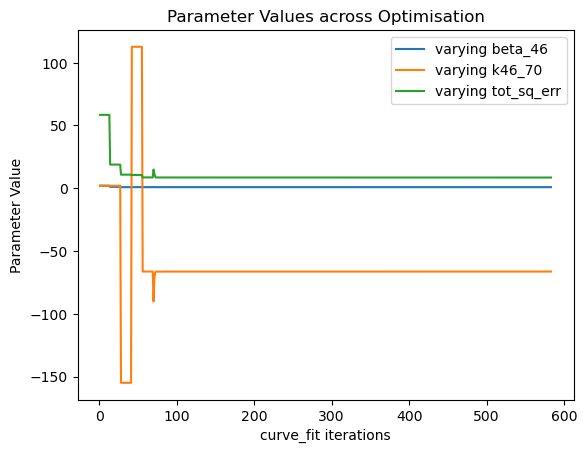

In [114]:
#taking the boss_cv.txt file and putting it into a pandas df
df_cv = pd.read_csv("minimise_output/boss_cv.txt", header=0, names = ["beta_46", "beta_50", "beta_54","beta_74","k46_50","k46_54","k46_70","k50_46","k50_54","k54_46","k54_70","k70_46","k70_54", "sq_err", "err_46", "err_50", "err_54", "err_70", "nowt4", "nowt5", "nowt6", "nowt7", "nowt8", "nowt9", "nowt10", "nowt11", "nowt12"])

#cool okay from this i can confirm the 0's i added to make curve_fit happy don't change throughout the test, so i'm confident they've worked well!
# test = df.drop(index=[0,1,2,3,4,5,6,7,8,10,11,12,13]) #so, what's interesting, is that without this line, the below graph makes no sense, just because of the scale it works at
beta46_array = df_cv['beta_46']
k4670_array = df_cv['k46_70']
lstsq_list = df_cv['sq_err']
iterations = np.linspace(1, len(beta46_array),len(beta46_array))

plt.title("Parameter Values across Optimisation")
plt.plot(iterations, beta46_array, label = 'varying beta_46')
plt.plot(iterations, k4670_array, label = 'varying k46_70')
plt.plot(iterations, lstsq_list, label = 'varying tot_sq_err')
plt.xlabel("curve_fit iterations")
plt.ylabel('Parameter Value')
plt.legend(loc = 'best')

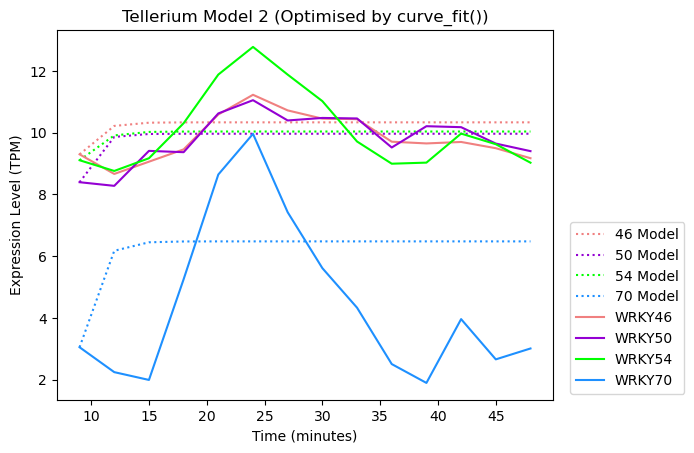

In [134]:
#modifying the tell_str with the minimised parameters

cv_parameters ={'beta_46':0.88690354, 'beta_50':1.98138626, 'beta_54':1.12892704 , 'beta_70':3.39913659 , 'k46_50':5.34729036, 'k46_70': 11.89474733, 'k46_54': 18.59806842, 'k50_46':13.25511262,'k50_54':12.14384048, 'k54_46':13.0973515, 'k54_70':18.60993505, 'k70_46':11.67056936, 'k70_54':10.94590068}

str_cv_boss = tell_str_var.format(**cv_parameters)
blockA_str = str_cv_boss
r = te.loada(blockA_str)
cv_results = r.simulate(int(timepoints[0]),int(timepoints[-1]),int(len(timepoints)))

# reorganising results to then plot with matching colour scheme as data
cv_results_df = pd.DataFrame(results)
cv_results_df = results_df.rename(columns={0:'time',1:'WRKY46', 2:'WRKY50', 3:'WRKY54', 4:'WRKY70'})

timepoints = np.arange(9,51,3)

plt.title('Tellerium Model 2 (Optimised by curve_fit())')
plt.plot(results_df['time'], results_df['WRKY46'], color='lightcoral', label='46 Model', linestyle = ':')
plt.plot(results_df['time'], results_df['WRKY50'], color='darkviolet', label='50 Model',linestyle = ':')
plt.plot(results_df['time'], results_df['WRKY54'], color='lime', label='54 Model',linestyle = ':')
plt.plot(results_df['time'], results_df['WRKY70'], color='dodgerblue', label='70 Model',linestyle = ':')
plt.plot(timepoints, inf_expA_df.iloc[0,1:15], label = "WRKY46", color = "lightcoral") 
plt.plot(timepoints, inf_expA_df.iloc[1,1:15], label = "WRKY50", color = "darkviolet")
plt.plot(timepoints, inf_expA_df.iloc[2,1:15], label = "WRKY54", color = "lime")
plt.plot(timepoints, inf_expA_df.iloc[3,1:15], label = "WRKY70", color = "dodgerblue")
plt.ylabel('Expression Level (TPM)', fontsize=10)
plt.xlabel('Time (minutes)', fontsize=10)

plt.legend(loc='upper center', bbox_to_anchor=(1.15, 0.5),
          ncol=1, fancybox=True)

## Using minimize() on the Tellerium Model

In [117]:
#this dictionary will be copied within mmte_tool. The copy is then modified and used to set parameters withint the Tellerium string at the placeholders.

mmte_parameters ={'beta_46':2, 'beta_50':2, 'beta_54':2, 'beta_70':2, 'k46_50':2, 'k46_70':2, 'k46_54':2, 'k50_46':2,'k50_54':2, 'k54_46':2, 'k54_70':2, 'k70_46':2, 'k70_54':2}

In [118]:
#definining a master function for minimise; note the additional optional outputs, however since minimise requires a scalar output, theses are commented out for now, and must be whenever you want minimise to call this function.

def mmte_tool(variables, time,title):
    """
    let variables be a list of [beta_46,beta_50,beta_54,beta_70,k46_50, k46_54, k46_70, k50_46,k50_54, k54_46, k54_70, k70_46, k70_54]
    timepoints should be an array.
    """
    if len(variables) == 13:
        totsq_list_x = []
        err_dict = {}
        mmte_parameters_temp = mmte_parameters.copy()
        mmte_parameters_temp['beta_46'] = variables[0] #sorry... this is so ugly </3
        mmte_parameters_temp['beta_50'] = variables[1]
        mmte_parameters_temp['beta_54'] = variables[2]
        mmte_parameters_temp['beta_70'] = variables[3]
        mmte_parameters_temp['k46_50'] = variables[4]
        mmte_parameters_temp['k46_54'] = variables[5]
        mmte_parameters_temp['k46_70'] = variables[6]
        mmte_parameters_temp['k50_46'] = variables[7]
        mmte_parameters_temp['k50_54'] = variables[8]
        mmte_parameters_temp['k54_46'] = variables[9]
        mmte_parameters_temp['k54_70'] = variables[10]
        mmte_parameters_temp['k70_46'] = variables[11]
        mmte_parameters_temp['k70_54'] = variables[12]
        str = tell_str_var.format(**mmte_parameters_temp)
        r = te.loada(str)
        results = r.simulate(int(time[0]),int(time[-1]),int(len(time)))
        results_df = pd.DataFrame(results)
        err_dict_temp ={}
        n = 1
        tot_sq_err = 0
        for gene in real_inf_df:
            pred = results_df.iloc[:,n]
            sq_mean_err = mean_squared_error(pred,real_inf_df[gene])
            err_dict_temp[n] = [sq_mean_err]
            tot_sq_err += sq_mean_err
            n += 1
        filepath = "/Users/guf24vol/Documents/training/training/minimise_output/" + f"{title}.txt"
        original = sys.stdout
        sys.stdout = open(filepath, "a") #note, need to make a new file eachtime this is ran
        print(f"{variables[0]},{variables[1]},{variables[2]},{variables[3]},{variables[4]},{variables[5]},{variables[6]},{variables[7]},{variables[8]},{variables[9]},{variables[10]},{variables[11]},{variables[12]},{tot_sq_err}")
        sys.stdout = original
        return tot_sq_err#, str, results_df, str, mmte_parameters_temp, err_dict_all
    else:
        print("unexpected variable input")
        return

In [119]:
#running minimise on the above function.
guess = list(np.full((13,), 2))
boss_min_res = minimize(mmte_tool,guess, (timepoints,"boss_min1"))
print(boss_min_res.x)

[0.20810459 1.60822723 0.38695214 0.80523043 2.05882449 2.01134016
 2.11387349 1.68182628 1.76338454 1.94626657 2.13161038 1.85593271
 2.06983151]


In [120]:
df = pd.read_csv("minimise_output/boss_min1.txt", header=0, names = ["beta_46", "beta_50", "beta_54","beta_74","k46_50","k46_54","k46_70","k50_46","k50_54","k54_46","k54_70","k70_46","k70_54", "sq_err"])
print(df)

       beta_46   beta_50   beta_54  beta_74    k46_50   k46_54    k46_70  \
0     2.000000  2.000000  2.000000  2.00000  2.000000  2.00000  2.000000   
1     2.000000  2.000000  2.000000  2.00000  2.000000  2.00000  2.000000   
2     2.000000  2.000000  2.000000  2.00000  2.000000  2.00000  2.000000   
3     2.000000  2.000000  2.000000  2.00000  2.000000  2.00000  2.000000   
4     2.000000  2.000000  2.000000  2.00000  2.000000  2.00000  2.000000   
...        ...       ...       ...      ...       ...      ...       ...   
1352  0.208105  1.608227  0.386952  0.80523  2.058824  2.01134  2.113873   
1353  0.208105  1.608227  0.386952  0.80523  2.058824  2.01134  2.113873   
1354  0.208105  1.608227  0.386952  0.80523  2.058824  2.01134  2.113873   
1355  0.208105  1.608227  0.386952  0.80523  2.058824  2.01134  2.113873   
1356  0.208105  1.608227  0.386952  0.80523  2.058824  2.01134  2.113873   

        k50_46    k50_54    k54_46   k54_70    k70_46    k70_54     sq_err  
0     2.00

In [131]:
#modifying the tell_str with the minimised parameters

min_parameters ={'beta_46':0.20810459, 'beta_50':1.60822723, 'beta_54':0.38695214, 'beta_70':0.80523043, 'k46_50':2.05882449, 'k46_70':2.01134016, 'k46_54': 2.11387349, 'k50_46':1.68182628,'k50_54':1.76338454, 'k54_46':1.94626657, 'k54_70':2.13161038, 'k70_46':1.85593271, 'k70_54':2.06983151}

str_min_boss = tell_str_var.format(**min_parameters)
blockA_str = str_min_boss
r = te.loada(blockA_str)
min_results = r.simulate(int(timepoints[0]),int(timepoints[-1]),int(len(timepoints)))


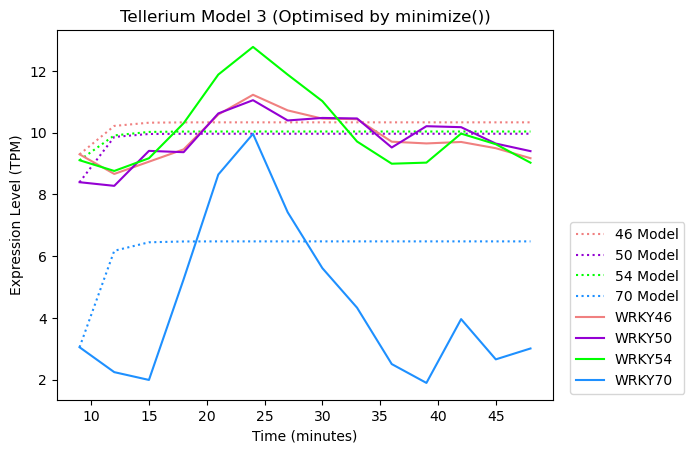

In [133]:

# reorganising results to then plot with matching colour scheme as data
min_results_df = pd.DataFrame(min_results)
min_results_df = results_df.rename(columns={0:'time',1:'WRKY46', 2:'WRKY50', 3:'WRKY54', 4:'WRKY70'})

timepoints = np.arange(9,51,3)

plt.title('Tellerium Model 3 (Optimised by minimize())')
plt.plot(results_df['time'], min_results_df['WRKY46'], color='lightcoral', label='46 Model', linestyle = ':')
plt.plot(results_df['time'], min_results_df['WRKY50'], color='darkviolet', label='50 Model',linestyle = ':')
plt.plot(results_df['time'], min_results_df['WRKY54'], color='lime', label='54 Model',linestyle = ':')
plt.plot(results_df['time'], min_results_df['WRKY70'], color='dodgerblue', label='70 Model',linestyle = ':')
plt.plot(timepoints, inf_expA_df.iloc[0,1:15], label = "WRKY46", color = "lightcoral") 
plt.plot(timepoints, inf_expA_df.iloc[1,1:15], label = "WRKY50", color = "darkviolet")
plt.plot(timepoints, inf_expA_df.iloc[2,1:15], label = "WRKY54", color = "lime")
plt.plot(timepoints, inf_expA_df.iloc[3,1:15], label = "WRKY70", color = "dodgerblue")
plt.ylabel('Expression Level (TPM)', fontsize=10)
plt.xlabel('Time (minutes)', fontsize=10)

plt.legend(loc='upper center', bbox_to_anchor=(1.15, 0.5),
          ncol=1, fancybox=True)

comparing the minimise and curve fit models...

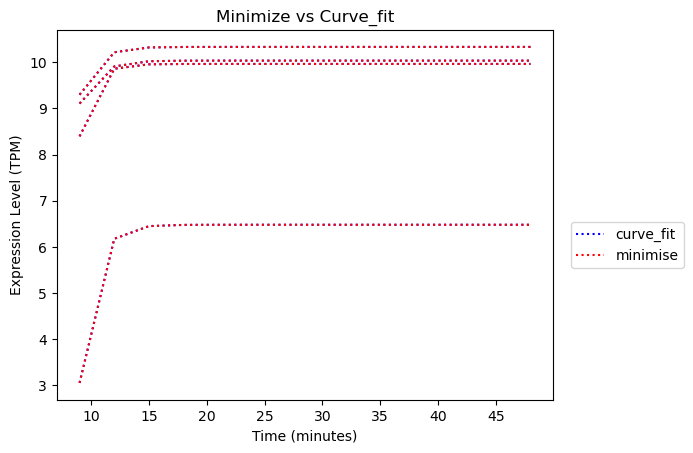

In [130]:
plt.title('Minimize vs Curve_fit')
plt.plot(results_df['time'], cv_results_df['WRKY46'], color='blue', label='curve_fit', linestyle = ':')
plt.plot(results_df['time'], cv_results_df['WRKY50'], color='blue',linestyle = ':')
plt.plot(results_df['time'], cv_results_df['WRKY54'], color='blue',linestyle = ':')
plt.plot(results_df['time'], cv_results_df['WRKY70'], color='blue',linestyle = ':')
plt.plot(results_df['time'], min_results_df['WRKY46'], color='red', linestyle = ':')
plt.plot(results_df['time'], min_results_df['WRKY50'], color='red',linestyle = ':')
plt.plot(results_df['time'], min_results_df['WRKY54'], color='red',linestyle = ':')
plt.plot(results_df['time'], min_results_df['WRKY70'], color='red', label='minimise',linestyle = ':')
plt.ylabel('Expression Level (TPM)', fontsize=10)
plt.xlabel('Time (minutes)', fontsize=10)

plt.legend(loc='upper center', bbox_to_anchor=(1.15, 0.5),
          ncol=1, fancybox=True)

i take this as definitive proof that these four genes aren't sufficient.
next steps:
* triple checking the robustness of all of this, in a tidy final script.
* modelling a repressor, or halflife activator.